In [36]:
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pymorphy2
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
morph = pymorphy2.MorphAnalyzer()

In [37]:
import pandas as pd
import numpy as np

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])#Делаем одинаковое количество негативынх и позиитвных твитов
raw_data = np.concatenate((data_positive['text'].values[:sample_size],#Соединяем
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [38]:
def replaceemoji_text(text):# Заменяем смайлы
    text = text.replace (":D"," улыбка")
    text = text.replace (":-D"," улыбка")
    text = text.replace ("=)"," улыбка")
    text = text.replace (":)"," улыбка")
    text = text.replace (":-)"," улыбка")
    text = text.replace (";)"," улыбка")
    text = text.replace (":("," грусть")
    text = text.replace (":|"," недоумение")
    text = text.replace (":-("," грусть")
    text = text.replace (":*"," улыбка")
    text = text.replace ("%)"," удивление")
    return text.strip()
raw_data = [replaceemoji_text(t) for t in raw_data]

In [39]:
def ReplaceTreeorMore(text):# Если в слове больше двух одинаковых букв, идущих подрядл, меняем на две одинаковые буквы
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    return pattern.sub(r"\1\1", text)
raw_data = [ReplaceTreeorMore(t) for t in raw_data]

In [40]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")# Меняем ё на е
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)# Меняем ссылки на URL
    text = re.sub('@[^\s]+', 'USER', text)# Пользователя на User
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)# Убираес все прочие занки кроме букв и цифр
    text = re.sub(' +', ' ', text)
    return text.strip()


raw_data = [preprocess_text(t) for t in raw_data]

In [42]:
x_train, x_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.2, random_state=2)

In [43]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

SENTENCE_LENGTH = 26 # Делаем количество слов в предложение равное 26. Если больше 26
NUM = 100000 # Часто повторяющейся слова

def get_sequences(tokenizer, x): # Чесли слов больше чем 26, то предложение обрезается, если меньше то заполняется нулями
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

Using TensorFlow backend.


In [44]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import gensim

In [45]:
w2v_model = Word2Vec.load('tweets_model.w2v') # В качесчте модели Word2vec решил взять модель уже обученную на русскоязычном сегменте твиттера.

In [46]:
from keras import backend as K 

# Метрики 
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [47]:
DIM = w2v_model.vector_size # Количествор векторов в  слове
embedding_matrix = np.zeros((NUM, DIM))
# Добавляем NUM=100000 наиболее часто встречающихся слов из обучающей выборки в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

In [48]:
from keras.layers import Input
from keras.layers.embeddings import Embedding

# Для создания модели, используем keras The Functional API
# Основа для модели взято отсюда https://arxiv.org/abs/1704.06125
tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32') # Описание парметра входа. Входная форма по 26 слов
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input) #Слой Emdedding. 

In [55]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary()# Модель с замороженными emdedding слоям

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 200)      20000000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 26, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 25, 1)        401         dropout_5[0][0]                  
____________________________________________________________________________________________

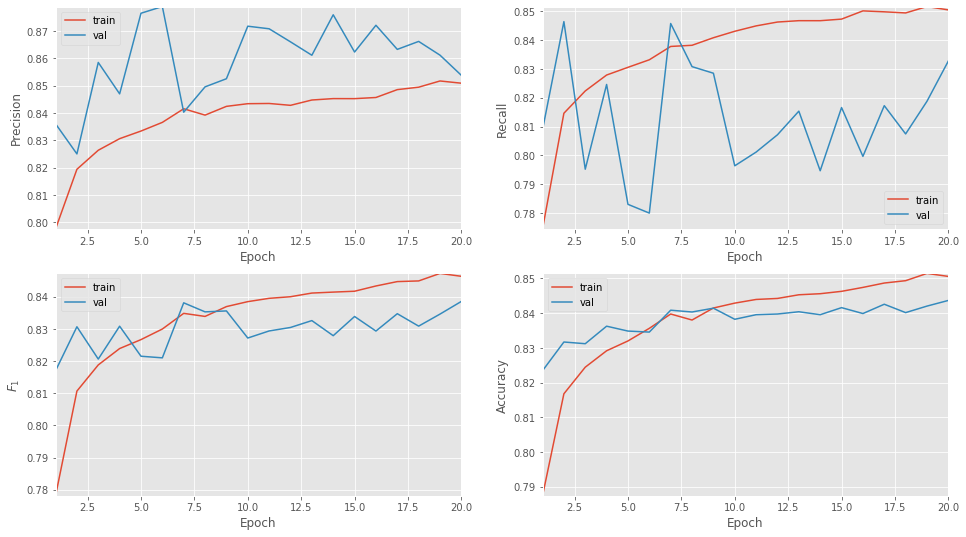

In [57]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    #plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [56]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=20, validation_split=0.2, callbacks = [checkpoint])

Train on 134307 samples, validate on 44769 samples
Epoch 1/20
134307/134307 [==============================] - 134s 998us/step - loss: 0.3975 - accuracy: 0.7874 - precision: 0.7976 - recall: 0.7744 - f1: 0.7781 - val_loss: 0.3402 - val_accuracy: 0.8234 - val_precision: 0.8361 - val_recall: 0.8089 - val_f1: 0.8170
Epoch 2/20
134307/134307 [==============================] - 130s 972us/step - loss: 0.3542 - accuracy: 0.8168 - precision: 0.8194 - recall: 0.8146 - f1: 0.8107 - val_loss: 0.3320 - val_accuracy: 0.8317 - val_precision: 0.8251 - val_recall: 0.8464 - val_f1: 0.8307
Epoch 3/20
134307/134307 [==============================] - 131s 975us/step - loss: 0.3425 - accuracy: 0.8244 - precision: 0.8264 - recall: 0.8224 - f1: 0.8188 - val_loss: 0.3299 - val_accuracy: 0.8312 - val_precision: 0.8585 - val_recall: 0.7952 - val_f1: 0.8206
Epoch 4/20
134307/134307 [==============================] - 130s 970us/step - loss: 0.3363 - accuracy: 0.8292 - precision: 0.8306 - recall: 0.8279 - f1: 0.82

In [63]:
model.load_weights('cnn-frozen-embeddings-07-0.84.hdf5')

In [64]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.84343   0.83858   0.84100     22457
           1    0.83847   0.84332   0.84089     22313

    accuracy                        0.84094     44770
   macro avg    0.84095   0.84095   0.84094     44770
weighted avg    0.84096   0.84094   0.84094     44770



In [61]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', precision, recall, f1])
model.summary()# Модель с размороженными emdedding слоям

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 200)      20000000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 26, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 25, 1)        401         dropout_5[0][0]                  
____________________________________________________________________________________________

In [62]:
checkpoint = ModelCheckpoint("cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

C:\Users\Nikita Khoriakov\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 134307 samples, validate on 44769 samples
Epoch 1/5
134307/134307 [==============================] - 1097s 8ms/step - loss: 0.2961 - accuracy: 0.8567 - precision: 0.8549 - recall: 0.8589 - f1: 0.8529 - val_loss: 0.3114 - val_accuracy: 0.8450 - val_precision: 0.8660 - val_recall: 0.8197 - val_f1: 0.8374
Epoch 2/5
134307/134307 [==============================] - 1076s 8ms/step - loss: 0.2885 - accuracy: 0.8600 - precision: 0.8579 - recall: 0.8624 - f1: 0.8562 - val_loss: 0.3096 - val_accuracy: 0.8464 - val_precision: 0.8678 - val_recall: 0.8207 - val_f1: 0.8388
Epoch 3/5
134307/134307 [==============================] - 1100s 8ms/step - loss: 0.2857 - accuracy: 0.8625 - precision: 0.8606 - recall: 0.8653 - f1: 0.8590 - val_loss: 0.3068 - val_accuracy: 0.8494 - val_precision: 0.8662 - val_recall: 0.8290 - val_f1: 0.8427
Epoch 4/5
134307/134307 [==============================] - 1128s 8ms/step - loss: 0.2790 - accuracy: 0.8667 - precision: 0.8649 - recall: 0.8689 - f1: 0.8631 - val

In [65]:
model.load_weights('cnn-trainable-03-0.84.hdf5')

In [66]:
predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.83412   0.87011   0.85173     22457
           1    0.86333   0.82584   0.84417     22313

    accuracy                        0.84805     44770
   macro avg    0.84872   0.84797   0.84795     44770
weighted avg    0.84868   0.84805   0.84796     44770

